In [1]:
!uname -a


Linux sambal 6.1.0-10-amd64 #1 SMP PREEMPT_DYNAMIC Debian 6.1.38-2 (2023-07-27) x86_64 GNU/Linux


In [2]:

!pip install wandb nltk torchinfo matplotlib==3.8.2 torch==2.1.2 torchvision==0.16.2 numpy pandas  python-dotenv psycopg2-binary  pinecone-client tensorflow_hub

In [2]:
import torch
import torch.nn as nn  # (i.e. "neural network")
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import wandb
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader

import tensorflow_hub as hub
USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/tmp/ipykernel_3228/2067779224.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-01 09:27:47.554716: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-01 09:27:47.786697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 09:27:

In [140]:
JSON_FILE = "./downloads/full_format_recipes.json"
dataset = pd.read_json(JSON_FILE)
dataset.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01 04:00:00+00:00,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20 04:00:00+00:00,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20 04:00:00+00:00,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27 04:00:00+00:00,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20 04:00:00+00:00,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


### clean the data

In [147]:
dataset = dataset[dataset['directions'].notna()]
dataset = dataset[dataset['rating'].notna()]
print("missing ingredients", dataset['ingredients'].isnull().sum())
print("missing ratings", dataset['rating'].isna().sum())
print("missing directions", dataset['directions'].isnull().sum())

missing ingredients 0
missing ratings 0
missing directions 0


directions     False
fat            False
date           False
categories     False
calories       False
desc           False
protein        False
rating         False
title          False
ingredients    False
sodium         False
dtype: bool

In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class DataFrameDataset(torch.utils.data.Dataset):
    def __init__(self, input):
        self.dataframe = pd.DataFrame()
        self.dataframe['rating'] = torch.tensor(input['rating'], dtype=torch.float) / 5.0
        self.dataframe['recipe'] = input.apply(self.format, axis=1)

        recipe = self.dataframe['recipe']
        good = recipe.apply(lambda x: isinstance(x, torch.Tensor))
        self.dataframe = self.dataframe[good]
        
        # non_tensors = self.dataframe['recipe'].map(lambda x: not isinstance(x, torch.Tensor))
        # self.dataframe['recipe'] = self.dataframe['recipe'][non_tensors]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        input = self.dataframe.iloc[idx]['recipe']
        label = self.dataframe.iloc[idx]['rating']
        return torch.tensor(input, dtype=torch.float), torch.tensor([label], dtype=torch.float)

    def embed(self, sentence):
        embedding = USE([sentence])
        return  torch.from_numpy(embedding.numpy()).float().squeeze(0)

    def format(self, data):
        ingredients = " ".join(data['ingredients']) if data['ingredients'] else ""
        steps = " ".join(data['directions']) if data['directions'] else ""
        recipe = f"TITLE: {data['title']} \nDESCRIPTION: {data['desc']} \nINGREDIENTS: {ingredients} \nINSTRUCTIONS: {steps}"
        return self.embed(recipe)

clean_data = DataFrameDataset(dataset)


In [159]:
recipe = clean_data.dataframe['recipe']
bad = recipe.apply(lambda x: not isinstance(x, torch.Tensor))
print(recipe[bad].shape)

(0,)


In [160]:
# 70% of processed_dataset is used for training
train_size = int(0.76 * len(clean_data))
# 15% of clean_data is used for validation
val_size = int(0.12 * len(clean_data))
# The remaining 15% is used for testing
test_size = len(clean_data) - train_size - val_size


train_data, val_data, test_data = torch.utils.data.random_split(
   clean_data, [train_size, val_size, test_size]
)

print(f"Total size: {len(clean_data)}")
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")


Total size: 20070
Train size: 15253
Test size: 2409
Val size: 2408


In [177]:

class StarModel(nn.Module):
    def __init__(self):
        super(StarModel, self).__init__()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        # Pass data through fc1
        x = self.fc1(x)
        # Use ReLU activation function
        x = F.relu(x)
        # Pass data through fc2
        x = self.fc2(x)
        # UsF.ReLU activation function
        x = F.relu(x)
        # Pass data through fc3
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x



In [187]:
print(type(train_data))

BATCH_SIZE = 128
# Number of epochs to train for
epochs = 8


# Create a DataLoader with batch size of 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# Define a loss function - Mean Squared Error is used here as an example
criterion = nn.MSELoss()

# Define an optimizer - Stochastic Gradient Descent is used here as an example
optimizer = optim.SGD(net.parameters(), lr=0.0001)


model = StarModel()
model.to(device)
model.train()


<class 'torch.utils.data.dataset.Subset'>


StarModel(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

8


/tmp/ipykernel_3228/3461303125.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.float), torch.tensor([label], dtype=torch.float)


Epoch 1/8 Loss: 0.15911194682121277
Epoch 2/8 Loss: 0.16134245693683624
Epoch 3/8 Loss: 0.10743139684200287
Epoch 4/8 Loss: 0.15251366794109344
Epoch 5/8 Loss: 0.12129287421703339
Epoch 6/8 Loss: 0.12029225379228592
Epoch 7/8 Loss: 0.13384616374969482
Epoch 8/8 Loss: 0.15007802844047546


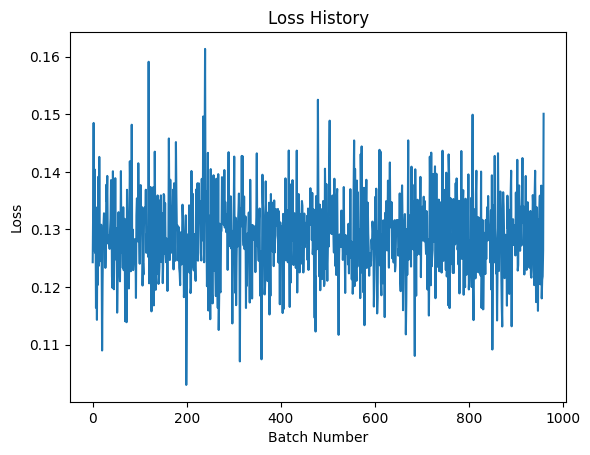

In [190]:
# Train the model
print(epochs)
loss_history = []
for epoch in range(epochs):
    for inputs, targets in train_loader:

        # print(inputs.shape, targets.shape)
        # print(targets[0].shape)

        # print(inputs, targets)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.to(device))

        # Calculate loss
        # print("Pred min, max: ", outputs.shape, outputs.min().item(), outputs.max().item())
        # print("Label min, max: ", targets.shape, targets.min().item(), targets.max().item())
        loss = criterion(outputs, targets.to(device))

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item()}")


# Plotting the loss history
plt.plot(loss_history)
plt.title('Loss History')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.show()

In [108]:
def test_train_loader(train_loader):
    for i, (data, labels) in enumerate(train_loader):
        # Check if data and labels are of type torch.Tensor
        assert isinstance(data, torch.Tensor), f"Data in batch {i} is not a torch.Tensor"
        assert isinstance(labels, torch.Tensor), f"Labels in batch {i} is not a torch.Tensor"
        
        # Check the dimensions of the data and labels
        # Assuming data should have dimensions [batch_size, 512] and labels [batch_size, 1]
        assert data.dim() == 2, f"Data in batch {i} does not have 2 dimensions"
        assert data.shape[1] == 512, f"Data in batch {i} does not have 512 features, has {data.shape[1]}"
        assert labels.dim() == 2, f"Labels in batch {i} do not have 2 dimensions"
        assert labels.shape[1] == 1, f"Labels in batch {i} are not single values, shape is {labels.shape}"
        
        # Optionally, check the range of data and labels if applicable
        # For example, if labels are ratings between 0 and 5
        assert labels.min() >= 0, f"Labels in batch {i} contain values less than 0"
        assert labels.max() <= 1, f"Labels in batch {i} contain values greater than 5"
        
        print(f"Batch {i} passed all tests.")

# Assuming train_loader is your DataLoader instance
test_train_loader(train_loader)


Batch 0 passed all tests.
Batch 1 passed all tests.


/tmp/ipykernel_3228/2007158972.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(input, dtype=torch.float), torch.tensor([label], dtype=torch.float)


RuntimeError: stack expects each tensor to be equal size, but got [512] at entry 0 and [] at entry 1